In [103]:
import wradlib as wrl
import matplotlib.pyplot as pl
import numpy as np
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

from osgeo import osr
import datetime as dt

In [104]:
filename = '2017030700000300dBuZ.vol'
rbdict = wrl.io.read_rainbow(filename)

In [105]:
rbdict['volume']['scan'].keys()

odict_keys(['@name', '@time', '@date', 'unitid', 'advancedchanged', 'detailedchanged', 'scantime', 'pargroup', 'slice'])

In [106]:
rbdict['volume']['sensorinfo']

OrderedDict([('@type', 'gdrx'),
             ('@id', '159THS'),
             ('@name', 'Phimai'),
             ('lon', '102.564160'),
             ('lat', '15.181940'),
             ('alt', '256.000000'),
             ('wavelen', '0.10676'),
             ('beamwidth', '0.976')])

In [108]:
lon = rbdict['volume']['sensorinfo']['lon']
lat = rbdict['volume']['sensorinfo']['lat']
alt = rbdict['volume']['sensorinfo']['alt']
sitecoords = (float(lon),float(lat), float(alt))

In [109]:
type(sitecoords)

tuple

In [110]:
int(rbdict['volume']['scan']['pargroup']['numele'])

14

In [122]:
elevs = []
numele = 7 #int(rbdict['volume']['scan']['pargroup']['numele'])

In [123]:
# setup projection for south india
# http://spatialreference.org/ref/epsg/kalianpur-1975-india-zone-iv/
# http://spatialreference.org/ref/epsg/wgs-84-utm-zone-47n/
proj = osr.SpatialReference()
proj.ImportFromEPSG(32647)

# get slices dict
slices = rbdict['volume']['scan']['slice']

# setup coord and data arrays
xyz, data = np.array([]).reshape((-1, 3)), np.array([])

In [125]:
# iterate over available slices
for nofslice in range(numele):

    # there are slices with 361 rays
    # make sure to only get first 360 rays
    azi = slices[nofslice]['slicedata']['rayinfo'][0]['data'][0:360]

    azidepth = float(
        slices[nofslice]['slicedata']['rayinfo'][0]['@depth'])

    # we want only 360 rays
    azi = azi * 360. / 2 ** azidepth
    # get azimuth of first ray
    zero_azi = int(round(azi[0]))
    # realign azimuth array to have 0deg as first ray
    azi = np.roll(azi, zero_azi, axis=0)

    # append slice elevation angle to elevs
    el = float(slices[nofslice]['posangle'])
    elevs.append(el)

    # stoprange is valid for all slices
    if nofslice == 0:
        stoprange = float(slices[nofslice]['stoprange'])
    # whereas rangestep is available in every slice
    rangestep = float(slices[nofslice]['rangestep'])

    # create range array and have it in meter
    r = np.arange(0 + rangestep/2, stoprange, rangestep) * 1000.

    # calculate slice coordinates
    xyz_ = wrl.vpr.volcoords_from_polar(sitecoords, el, azi, r, proj)

    # get data, make sure to only get the first 360 rays
    data_ = slices[nofslice]['slicedata']['rawdata']['data'][0:360,:]
    datadepth = float(slices[nofslice]['slicedata']['rawdata']['@depth'])
    datamin = float(slices[nofslice]['slicedata']['rawdata']['@min'])
    datamax = float(slices[nofslice]['slicedata']['rawdata']['@max'])
    data_ = datamin + data_ * (datamax - datamin) / 2 ** datadepth

    # make sure the data is aligned to zero azimuth == due north
    data_ = np.roll(data_, zero_azi, axis=0)

    # stack up coords and data
    xyz, data = np.vstack((xyz, xyz_)), np.append(data, data_.ravel())

print("Available elevations: {0}".format(elevs))

Available elevations: [0.5, 1.5, 2.4, 3.3, 4.3, 5.2, 6.2]


In [142]:
maxrange = 250000.
maxalt = 15000.
horiz_res = 1000.
vert_res = 250.

trgxyz, trgshape = wrl.vpr.make_3d_grid(sitecoords, proj, maxrange,maxalt, horiz_res, vert_res)

In [143]:
trgshape

(61, 501, 502)

In [144]:
minelev = 0.2
maxelev = 21.0
tstart = dt.datetime.now()

print(xyz)
print(trgxyz)
print(trgshape)
print(maxrange)
print(minelev)
print(maxelev)

gridder = wrl.vpr.CAPPI(xyz, trgxyz, trgshape, maxrange, minelev, maxelev)
print("Creating CAPPI instance took {} seconds.".format((dt.datetime.now() - tstart).total_seconds()))

[[8.83176349e+05 1.68134969e+06 2.58185309e+02]
 [8.83403945e+05 1.68090374e+06 2.62577978e+02]
 [8.83631539e+05 1.68045778e+06 2.67000047e+02]
 ...
 [7.11484205e+05 1.51845870e+06 2.93431403e+04]
 [7.11126172e+05 1.51811870e+06 2.94109624e+04]
 [7.10768145e+05 1.51777870e+06 2.94788132e+04]]
[[ 633062.55065734 1431572.66880169       0.        ]
 [ 634062.55065734 1431572.66880169       0.        ]
 [ 635062.55065734 1431572.66880169       0.        ]
 ...
 [1132062.55065734 1931572.66880169   15000.        ]
 [1133062.55065734 1931572.66880169   15000.        ]
 [1134062.55065734 1931572.66880169   15000.        ]]
(61, 501, 502)
250000.0
0.2
21.0
Creating CAPPI instance took 18.952629 seconds.


In [145]:
vol = np.ma.masked_invalid(gridder(data).reshape(trgshape))
print("3-D interpolation took:", dt.datetime.now() - tstart)

3-D interpolation took: 0:00:21.576464


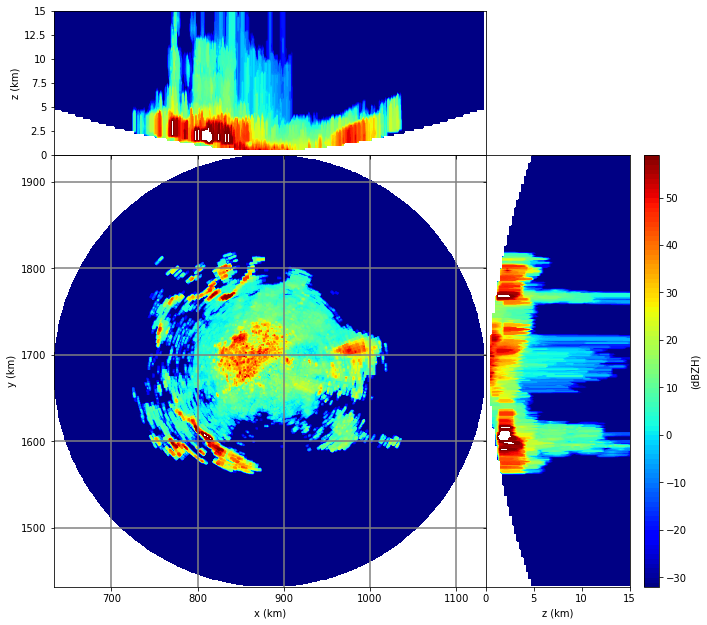

In [147]:
# diagnostic plot
trgx = trgxyz[:, 0].reshape(trgshape)[0, 0, :]
trgy = trgxyz[:, 1].reshape(trgshape)[0, :, 0]
trgz = trgxyz[:, 2].reshape(trgshape)[:, 0, 0]
wrl.vis.plot_max_plan_and_vert(trgx, trgy, trgz, vol, unit="dBZH",
                               levels=range(-32, 60,),cmap='jet')